# Chest X-ray classification

In [2]:
#importing the necessary libraries

import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image

In [3]:
#loading the images from folder

test_data_dir='Covid19-dataset\\test'
train_data_dir='Covid19-dataset\\train'

In [4]:
covid_images = [os.path.join(train_data_dir, 'Covid', path) for path in os.listdir(train_data_dir + '/Covid')]
normal_images = [os.path.join(train_data_dir, 'Normal', path) for path in os.listdir(train_data_dir + '/Normal')]
viral_pneumonia_images = [os.path.join(train_data_dir, 'Viral Pneumonia', path) for path in os.listdir(train_data_dir + '/Viral Pneumonia')]

In [5]:
#getting images respectively from each folder to show the images

covid_image=Image.open(covid_images[0])
normal_image=Image.open(normal_images[0])
pneumonia_image=Image.open(viral_pneumonia_images[0])

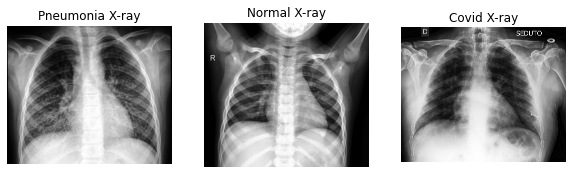

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(np.array(pneumonia_image))
plt.title("Pneumonia X-ray")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.array(normal_image))
plt.title('Normal X-ray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.array(covid_image))
plt.title('Covid X-ray')
plt.axis('off')
plt.show()

In [13]:
#performing data augmentation

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [32]:
#generating images with augmentation for model

img_width, img_height = 224, 224
batch_size = 8

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [15]:
x, y = next(train_generator)

In [16]:
x.shape

(8, 224, 224, 3)

In [43]:
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = tf.keras.layers.Dropout(rate=0.5)(global_avg_pooling) 
output = tf.keras.layers.Dense(3, activation='softmax')(dropout)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [18]:
history = model.fit(train_generator, epochs=60, validation_data=test_generator, verbose=1)

Epoch 1/60
32/32 [==============================] - 62s 1s/step - loss: 1.1612 - accuracy: 0.4343 - val_loss: 1.1103 - val_accuracy: 0.3030
Epoch 2/60
32/32 [==============================] - 35s 1s/step - loss: 0.9246 - accuracy: 0.5657 - val_loss: 1.1904 - val_accuracy: 0.3030
Epoch 3/60
32/32 [==============================] - 36s 1s/step - loss: 0.7339 - accuracy: 0.6853 - val_loss: 1.1975 - val_accuracy: 0.2121
Epoch 4/60
32/32 [==============================] - 35s 1s/step - loss: 0.5190 - accuracy: 0.7928 - val_loss: 1.1617 - val_accuracy: 0.4091
Epoch 5/60
32/32 [==============================] - 37s 1s/step - loss: 0.5097 - accuracy: 0.7928 - val_loss: 1.2365 - val_accuracy: 0.3939
Epoch 6/60
32/32 [==============================] - 38s 1s/step - loss: 0.4097 - accuracy: 0.8287 - val_loss: 1.4379 - val_accuracy: 0.3939
Epoch 7/60
32/32 [==============================] - 35s 1s/step - loss: 0.3554 - accuracy: 0.8645 - val_loss: 1.5520 - val_accuracy: 0.3939
Epoch 8/60
32/32 [==

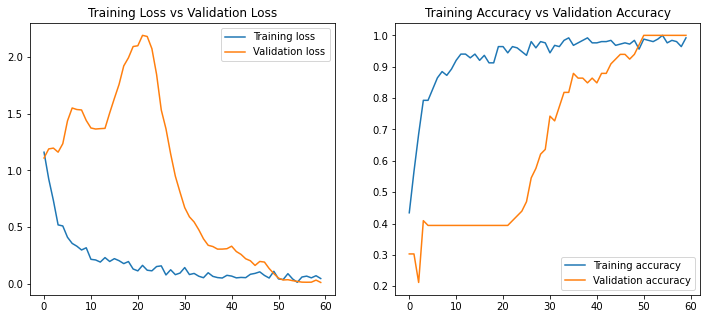

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(60), history.history['loss'], label='Training loss')
plt.plot(range(60), history.history['val_loss'], label='Validation loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(60), history.history['accuracy'], label='Training accuracy')
plt.plot(range(60), history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()
plt.show()

In [22]:
from tqdm import tqdm

In [23]:
all_batches = []
count = 1
for batch in tqdm(test_generator):
    all_batches.append(batch)
    count = count + 1
    if count == 33:
        break

31it [00:04,  7.24it/s]


In [24]:
all_y_hats = []
all_y = []
for X, y in all_batches:
    y_hat = model.predict(X)
    y_hat = np.argmax(y_hat, 1)
    all_y_hats.extend(list(y_hat))
    all_y.extend(list(np.argmax(y, 1)))

In [25]:
from sklearn.metrics import classification_report

In [26]:
print(classification_report(all_y, all_y_hats))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00        70
           2       1.00      1.00      1.00        75

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



In [27]:
from tensorflow.keras.models import load_model

model.save('covid_best.h5')

C:\Users\Tulsi\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [45]:
from tensorflow.keras.preprocessing import image

In [46]:
pred = model.predict(test_generator)

In [47]:
print(pred)

[[0.02166505 0.6684883  0.3098466 ]
 [0.02528026 0.6868662  0.28785342]
 [0.02207315 0.67784727 0.3000796 ]
 [0.02220755 0.67225116 0.3055413 ]
 [0.02265976 0.68587303 0.29146722]
 [0.02156707 0.66971314 0.30871978]
 [0.02446    0.6815039  0.29403615]
 [0.02149842 0.66778755 0.31071404]
 [0.02439688 0.68138313 0.29421994]
 [0.02094972 0.66234565 0.31670457]
 [0.02005275 0.65216905 0.32777816]
 [0.01970984 0.62364656 0.35664362]
 [0.02407983 0.681412   0.29450813]
 [0.02492833 0.6762256  0.29884604]
 [0.02502686 0.6895376  0.28543553]
 [0.01941101 0.65043306 0.33015588]
 [0.02022149 0.6543826  0.3253959 ]
 [0.01862625 0.6394996  0.34187418]
 [0.02149221 0.66054285 0.31796494]
 [0.02360225 0.6835604  0.2928374 ]
 [0.02069735 0.66262674 0.31667584]
 [0.0227175  0.6716025  0.30568004]
 [0.01940782 0.6405087  0.3400835 ]
 [0.02084757 0.66258705 0.3165654 ]
 [0.01946618 0.6344336  0.34610018]
 [0.01959904 0.6344368  0.34596416]
 [0.02516775 0.68881774 0.28601447]
 [0.02043718 0.6550717  0.32

In [48]:
New_Img_Path = "Covid19-dataset/test/Normal/0120.jpeg"
IMG_Load = image.load_img(New_Img_Path,target_size=(224,224))

In [49]:
N_IMG_Array = image.img_to_array(IMG_Load)

In [50]:
print(N_IMG_Array.shape)

(224, 224, 3)


In [51]:
N_IMG_Array = np.expand_dims(N_IMG_Array,axis=0)

In [52]:
label = test_generator.classes
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [53]:
New_Predict = model.predict(N_IMG_Array)

In [54]:
print(New_Predict)

[[5.3009443e-04 9.9522424e-01 4.2456095e-03]]


[1]


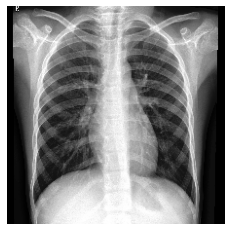

THE X-RAY IS NORMAL


In [55]:
classes = np.argmax(New_Predict, axis = 1)
print(classes)
plt.imshow(IMG_Load)
plt.axis('off')
plt.show()
if classes == 0:
    print("THE X-RAY IS COVID")
elif classes == 1:
    print("THE X-RAY IS NORMAL")
elif classes == 2:
    print("THE X-RAY IS PNEUMONIA")